# Lesson 8: break-aware gap filling 
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: FY3B soil moisture**

**Application: Henan, China**

**Gap filling** is the procedure of reconstructing missing or invalid data (e.g., due to cloud cover, sensor malfunction, or acquisition gaps) by estimating plausible values based on the available temporal, spatial, or spectral information.

The FY-3B satellite, a polar-orbiting meteorological satellite launched on 5 November 2010, provides valuable soil moisture (SM) observations.The spatial resolution is 25 km. However, due to the discontinuous spatial coverage of its revisit orbits, the original FY-3B SM data contain substantial temporal gaps. To address this issue, Wang et al. [1] developed a daily FY-3B SM dataset using a Temporal Convolutional Network (TCN) for gap filling. In this lesson, we simulate the original FY-3B SM data gaps by randomly removing portions of daily observations from Wang’s dataset. We then apply the Spatial–Continuous Change Detection (S-CCD) algorithm to perform gap filling. Finally, we compare the daily SM results obtained from S-CCD and TCN to evaluate their relative performance.


*[1] Wang, Q., You, Y., Yang, H., Xu, R., Zhang, H. K., Lu, P., & Tong, X. (2025). A TCN-Transformer Parallel model for reconstruction of a global, daily, spatially seamless FY-3B soil moisture dataset. Remote Sensing of Environment, 328, 114841.*


We use the S-CCD model fit to perform gap filling. Compared with a single global fit, S-CCD first identifies temporal breaks and then fits the time series segment by segment, which generally leads to a smaller RMSE than one-time fitting. There are three common configurations for model fitting in S-CCD (see Lesson 5 for details): (1) directly summing up of all state components; (2) applying lasso regression using all observations within a segment (`fitting_coefs=True`); (3) using the time-specific harmonic model coefficients at the last observation filtered by Kalman filter (`fitting_coefs=False`);

For gap filling, we recommended using the first approach, i.e., summing up all the state components, to pursue the best fitting that accounts for the local fluctuations. We need to output S-CCD states by setting `state_intervaldays` to perform the best gap filling.

---

## Daily soil moisture dataset


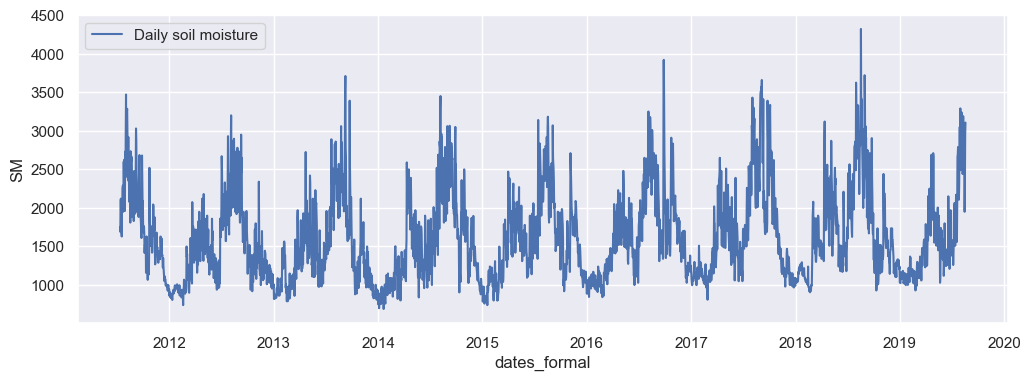

In [1]:
import numpy as np
import pathlib
import pandas as pd
from typing import List, Tuple, Dict, Union, Optional
from matplotlib.axes import Axes
import seaborn as sns
import matplotlib.pyplot as plt
from pyxccd import sccd_detect
from pyxccd.common import SccdOutput
from pyxccd.utils import getcategory_sccd, defaults

TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '8_gapfilling_FY3B.csv'

# read example csv for HLS time series
data = pd.read_csv(in_path)
calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data["dates"]]
data.loc[:, 'dates_formal'] = calendar_dates
data.SM = data.SM.multiply(10000)
# split the array by the column
# dates, SM = data.to_numpy().copy().T

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 4))
g = sns.lineplot(
    x="dates_formal", y="SM",
    data=data,
    label="Daily soil moisture",
    ax = ax
)

## Gap filling for sampled time series

Text(0.5, 1.0, 'TCN vs S-CCD fitting')

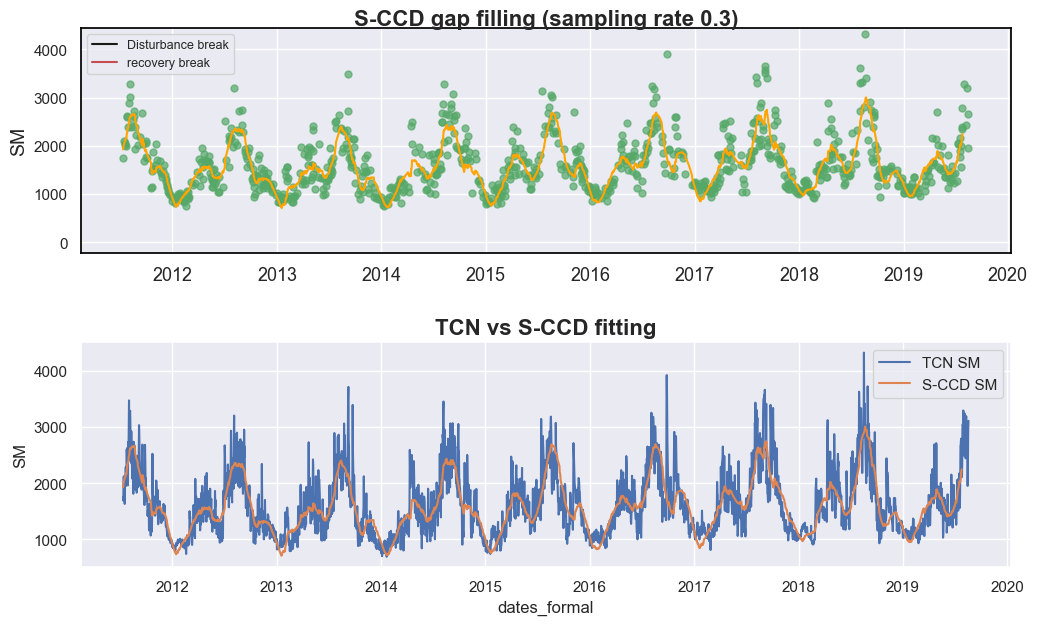

In [2]:
import pandas as pd
import numpy as np
import pathlib
from dateutil import parser
import pathlib
from datetime import date
from typing import List, Tuple, Dict, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

from pyxccd import sccd_detect_flex
from pyxccd.utils import defaults, predict_ref
from pyxccd.common import SccdOutput, cold_rec_cg, anomaly

def display_sccd_result_single(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    states:Optional[pd.DataFrame] = None,
    trimodal: bool = False,
    anomaly:Optional[anomaly] = None,
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
    
    states: pd.Dataframe
        S-CCD state outputs
        
    trimodal: bool
        indicate whether using trimodal
    
    anomaly: anomaly, optional
        The anomaly detection outputs
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    if trimodal:
        n_coefs = 8
    else:
        n_coefs = 6
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    if states is not None:
        if trimodal is True:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']+states['b0_trimodal']
        else:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
        states.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=states,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()
    else:
        for segment in sccd_result.rec_cg:
            j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': j * 0
                })

            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
                })
                

            # Convert dates and plot model fit
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()

        # Plot near-real-time projection for SCCD if available
        if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
            recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
            j = np.arange(
                sccd_result.nrt_model['t_start_since1982'] + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
                recent_obs[-1]+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
                1
            )

            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
                })
            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': j * 0
                })
                
            plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()
            
    # add manual legends
    if anomaly is not None:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                            Line2D([0], [0], label='recovery break', color='r'),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="black",
                            label='Disturbance anomalies', lw=0, markersize=8),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="red",
                            label='Recovery anomalies', lw=0, markersize=8)]
    else:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                    Line2D([0], [0], label='recovery break', color='r')]
    axe.legend(handles=legend_elements, loc='upper left', prop={'size': 9})
    
    # plot breaks
    for i in range(len(sccd_result.rec_cg)):
        # we used the sign of change magnitude to decide the category of the breaks
        if sccd_result.rec_cg[i]['magnitude'] < 0:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
   
    
    # plot anomalies if available
    if anomaly is not None:
        for i in range(len(anomaly.rec_cg_anomaly)):
            pred_ref = np.asarray(
                    [
                        predict_ref(
                            anomaly.rec_cg_anomaly[i]["coefs"][0],
                            anomaly.rec_cg_anomaly[i]["obs_date_since1982"][i_conse]
                            + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], num_coefficients=n_coefs
                        ) for i_conse in range(3)
                    ]
            )

            cm = anomaly.rec_cg_anomaly[i]["obs"][0, 0: 3] - pred_ref
            
            # gpp increase is black line
            if np.median(cm) > 0:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ro',fillstyle='none',markersize=8)         
            # gpp decrease is red line
            else:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ko',fillstyle='none',markersize=8) 
        
    axe.set_ylabel(f"{band_name}", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)



sampling_rate = 0.3
data_selected = data.sample(int(len(data) * sampling_rate))

data_selected['qa'] = np.zeros(data_selected.shape[0])

# need to multiply by 10000 to scale up into integer
dates, sm,  qas = data_selected[['dates', 'SM', 'qa']].to_numpy().astype(np.int64).copy().T


fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

# we used lam=0 and trimodal=True to achieve the best model fitting although might over-detect breaks
sccd_results, states = sccd_detect_flex(dates, sm, qas, lam=0, trimodal=True, state_intervaldays=1)
states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']+states['b0_trimodal']
calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
states.loc[:, 'dates_formal'] = calendar_dates

display_sccd_result_single(data=data_selected[['dates', 'SM', 'qa']].to_numpy(), band_names=['SM'], band_index=0, sccd_result=sccd_results, axe=axes[0], trimodal=True, states=states, title=f"S-CCD gap filling (sampling rate {sampling_rate})")

g = sns.lineplot(
    x="dates_formal", y="SM",
    data=data,
    label="TCN SM",
    ax = axes[1]
)
g = sns.lineplot(
    x="dates_formal", y="predicted",
    data=states,
    label="S-CCD SM",
    ax = axes[1]
)

axes[1].set_title('TCN vs S-CCD fitting', fontsize=16, fontweight='bold')

Compared with the Temporal Convolutional Network (TCN), the S-CCD method produces smoother soil moisture trajectories, whereas the TCN-derived curves exhibit greater fluctuations. This difference arises because the TCN predictions incorporate multiple environmental variables, while S-CCD relies primarily on an autoregressive temporal model. Given that soil moisture dynamics typically exhibit strong temporal persistence and depend on multi-day antecedent conditions, the smoother curves generated by S-CCD may better represent the actual physical processes—although this has not yet been quantitatively validated in our case.

Notably, compared with traditional harmonic regression techniques for time-series reconstruction, such as HANTS, S-CCD offers two major advantages:

- Accounting for local fluctuations: S-CCD performs model fitting adaptively in local temporal windows, enabling it to capture short-term variations such as the local peak observed at the end of 2018 in this case.

- Addressing structural breaks related to land-cover dynamics: When land-cover changes occur, the existing model coefficients may become invalid. CCDC-like approaches, including S-CCD, automatically reconstruct model parameters to accommodate such non-stationary conditions, thereby maintaining model robustness over time.

## Trying different temporal density
Let's try increasing sampling rate and see if the S-CCD prediction is stable

Text(0.5, 1.0, 'TCN vs S-CCD (sampling rate=0.7)')

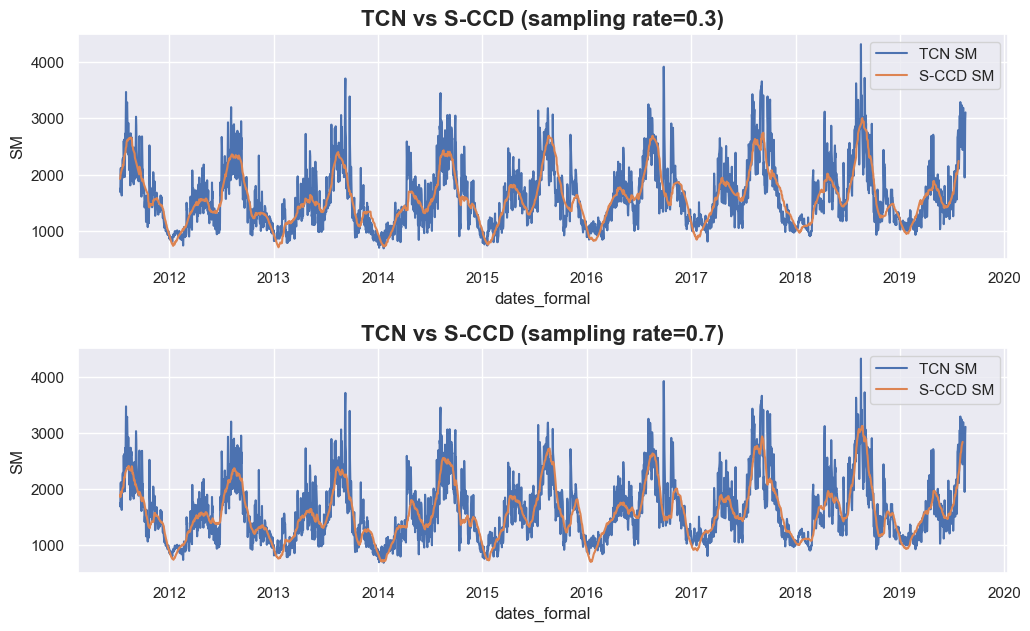

In [3]:
sampling_rate = 0.7
data_selected = data.sample(int(len(data) * sampling_rate))

data_selected['qa'] = np.zeros(data_selected.shape[0])

# need to multiply by 10000 to scale up into integer
dates, sm,  qas = data_selected[['dates', 'SM', 'qa']].to_numpy().astype(np.int64).copy().T


fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

sccd_results2, states2 = sccd_detect_flex(dates, sm, qas, p_cg=0.999, lam=0, trimodal=True, state_intervaldays=1)
states2['predicted'] = states2['b0_trend']+states2['b0_annual']+states2['b0_semiannual']+states2['b0_trimodal']
calendar_dates2 = [pd.Timestamp.fromordinal(int(row)) for row in states2["dates"]]
states2.loc[:, 'dates_formal'] = calendar_dates2


g = sns.lineplot(
    x="dates_formal", y="SM",
    data=data,
    label="TCN SM",
    ax = axes[0]
)
g = sns.lineplot(
    x="dates_formal", y="predicted",
    data=states,
    label="S-CCD SM",
    ax = axes[0]
)


g = sns.lineplot(
    x="dates_formal", y="SM",
    data=data,
    label="TCN SM",
    ax = axes[1]
)
g = sns.lineplot(
    x="dates_formal", y="predicted",
    data=states2,
    label="S-CCD SM",
    ax = axes[1]
)

axes[0].set_title('TCN vs S-CCD (sampling rate=0.3)', fontsize=16, fontweight='bold')
axes[1].set_title('TCN vs S-CCD (sampling rate=0.7)', fontsize=16, fontweight='bold')

From the above results, when we increased sampling rate from 0.3 to 0.7, the fitting curves of S-CCD (yellow ones) shows only slightly different gap filling results (such as `sampling rate=0.3` achieves lower value for the first peak in 2014), which suggested the performance of gap filling is generally robust at different sampling rates.